# Lab 6: Trees and forests

The goal of this lab is to explore and understand tree-based models on classification problems.

We will focus successively on decision trees, bagging trees and random forests. 

### Import required libraries

In [20]:
# import required libraries
import time
import math
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Classification data
We will use the same data as in Lab 4: the samples are tumors, each described by the expression (= the abundance) of 3,000 genes. The goal is to separate the endometrium tumors from the uterine ones.

In [21]:
# load the endometrium vs. uterus tumor data
endometrium_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
endometrium_data.head(n=5)  # adjust n to view more data

,ID_REF,1554530_at,1553185_at,1554340_a_at,1556202_at,1553957_at,1555469_a_at,1553660_at,1554681_a_at,1554938_a_at,...,1553967_at,1553362_at,1553002_at,1556194_a_at,1556420_s_at,1555855_at,1554508_at,1555097_a_at,1556371_at,Tissue
0,117722,10.8,13233.7,27.2,167.8,450.7,283.8,6.4,8.6,26.7,...,165.2,43.7,77.0,42.2,154.8,266.6,444.0,66.9,50.6,Endometrium
1,76638,12.6,4986.8,1.7,221.1,380.8,394.3,121.2,8.0,153.8,...,190.7,3.2,84.0,183.0,288.0,20.6,99.3,6.4,12.2,Endometrium
2,88952,16.6,6053.8,121.4,342.7,217.6,367.9,159.7,10.8,124.4,...,95.9,17.1,72.3,292.9,209.5,11.6,51.3,33.8,33.4,Endometrium
3,76632,9.9,6109.1,23.0,139.3,501.8,289.9,101.7,9.7,204.8,...,235.1,37.9,81.5,109.3,537.7,58.7,73.9,58.9,15.4,Endometrium
4,88966,13.1,8430.9,17.4,29.4,449.1,248.2,104.1,11.2,94.5,...,125.0,59.9,186.8,122.5,355.2,65.1,139.9,14.1,11.2,Endometrium


In [22]:
# Create the design matrix and target vector
X = endometrium_data.drop(['ID_REF', 'Tissue'], axis=1).values
y = pd.get_dummies(endometrium_data['Tissue']).values[:,1]

In [23]:
## make folds
from sklearn import model_selection
skf = model_selection.StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
folds = [(tr,te) for (tr,te) in skf.split(X, y)]

### Cross-validation procedures

In [24]:
def cross_validate_clf(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        pos_idx = list(classifier.classes_).index(1)
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:, pos_idx]
    return pred

In [25]:
def cross_validate_clf_optimize(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        print(classifier.best_params_)
        pos_idx = list(classifier.best_estimator_.classes_).index(1)
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:, pos_idx]
    return pred

# 1. Decision Trees
A decision tree predicts the value of a target variable by learning simple decision rules inferred from the data features.

In scikit-learn, they are implemented in [tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for classification and [tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for regression.

In [26]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

## 1.1 Toy dataset
In order to better understand how a decision tree processes the feature space, we will first work on a simulated dataset. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """


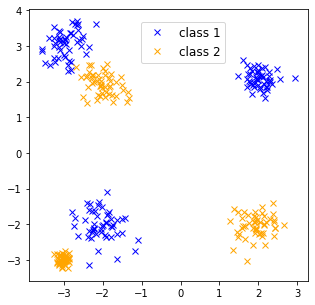

In [31]:
plt.figure(figsize=(5, 5))

x1 = np.random.multivariate_normal([2,2], [[0.1,0],[0,0.1]], 50)
x2 = np.random.multivariate_normal([-2,-2], [[0.1,0],[0,0.1]], 50)
x3 = np.random.multivariate_normal([-3,3], [[0.1,0.1],[0,0.1]], 50)
X1 = np.concatenate((x1,x2,x3), axis=0)

y1 = np.random.multivariate_normal([-2,2], [[0.1,0],[0,0.1]], 50)
y2 = np.random.multivariate_normal([2,-2], [[0.1,0],[0,0.1]], 50)
y3 = np.random.multivariate_normal([-3,-3], [[0.01,0],[0,0.01]], 50)
X2 = np.concatenate((y1,y2,y3), axis=0)

plt.plot(X1[:,0],X1[:,1], 'x', color='blue', label='class 1')
plt.plot(X2[:,0], X2[:,1], 'x', color='orange', label='class 2')


plt.legend(loc=(0.4, 0.8), fontsize=12)

**Question:** What do you expect the decision boudaries to look like ? 

__Answer:__

__Question:__ Fill-in the following code to train a decision tree on this toy data and visualize it. 

Change the splitter to random, meaning that the algorithm will consider the feature along which to split _randomly_ (rather than picking the optimal one), and then select the best among several _random_ splitting point. Run the algorithm several times. What do you observer?

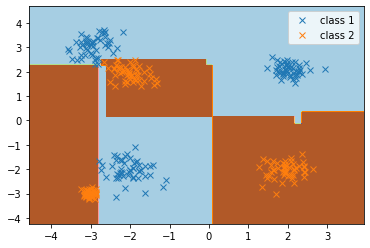

In [35]:
# Training data
X_demo = np.concatenate((X1, X2), axis=0)
y_demo = np.concatenate((np.zeros(X1.shape[0]), np.ones(X2.shape[0])))

# Train a DecisionTreeClassifier on the training data

clf = DecisionTreeClassifier().fit(X_demo,y_demo)

# Create a mesh, i.e. a fine grid of values between the minimum and maximum
# values of x1 and x2 in the training data
plot_step = 0.02
x_min, x_max = X_demo[:, 0].min() - 1, X_demo[:, 0].max() + 1
y_min, y_max = X_demo[:, 1].min() - 1, X_demo[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

# Label each point of the mesh with the trained DecisionTreeClassifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contours corresponding to these labels 
# (i.e. the decision boundary of the DecisionTreeClassifier)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Plot the training data 
plt.plot(X1[:,0], X1[:,1], 'x', label='class 1')
plt.plot(X2[:,0], X2[:,1], 'x', label='class 2')
plt.legend()

## 1.2 Tumor classification data

Let us now go back to our tumor classification problem.

**Question:** Cross-validate 5 different decision trees (with default parameters) and print out their accuracy. Why do you get different values? Check the documentation for help.

In [29]:
from sklearn import tree
from sklearn import metrics

ypred_dt = [] # will hold the 5 arrays of predictions (1 per tree)
for tree_index in range(5):
    # Initialize a DecisionTreeClassifier
    clf = DecisionTreeClassifier()
    
    # Cross-validate this DecisionTreeClassifier on the toy data
    pred_proba = cross_validate_clf(X, y, clf, folds)
    
    # Append the prediction to ypred_dt 
    ypred_dt.append(pred_proba)
    
    # Print the accuracy of DecisionTreeClassifier
    print("%.3f" % metrics.accuracy_score(y, np.where(pred_proba > 0.5, 1, 0)))

0.574
0.590
0.601
0.579
0.601


__Answer:__

**Question:** Compute the mean and standard deviation of the area under the ROC curve of these 5 trees. Plot the ROC curves of these 5 trees.

Use the [metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module of scikit-learn.

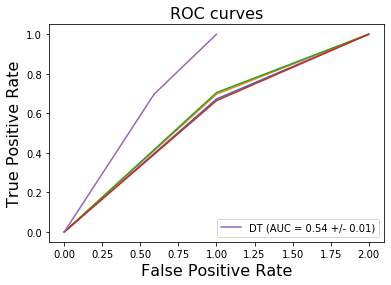

In [30]:
fpr_dt = [] # will hold the 5 arrays of false positive rates (1 per tree)
tpr_dt = [] # will hold the 5 arrays of true positive rates (1 per tree)
auc_dt = [] # will hold the 5 areas under the ROC curve (1 per tree)

for tree_index in range(5):
    # Compute the ROC curve of the current tree
    fpr_dt_tmp, tpr_dt_tmp, thresholds =  metrics.roc_curve(y,ypred_dt[tree_index],pos_label=1)
        
    # Compute the area under the ROC curve of the current tree
    auc_dt_tmp = metrics.auc(fpr_dt_tmp, tpr_dt_tmp)
    fpr_dt.append(fpr_dt_tmp)
    tpr_dt.append(tpr_dt_tmp)
    auc_dt.append(auc_dt_tmp)

# Plot the first 4 ROC curves
for tree_index in range(4):
    plt.plot(tpr_dt[tree_index])
            
# Plot the last ROC curve, with a label that gives the mean/std AUC
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', 
         label='DT (AUC = %0.2f +/- %0.2f)' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

**Question:** What parameters of DecisionTreeClassifier can you play with to define trees differently than with the default parameters? Cross-validate these using a grid search with [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Plot the optimal decision tree on the previous plot. Did you manage to improve performance?

C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 2000}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 20, 'max_features': 2000}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'gini', 'max_depth': 4, 'max_features': 1000}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 1000}
{'criterion': 'gini', 'max_depth': 20, 'max_features': 500}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


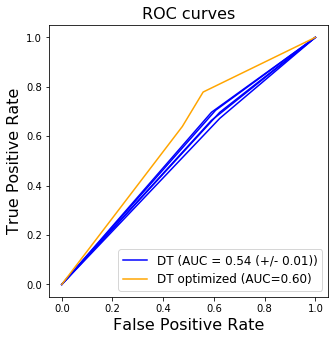

In [36]:

from sklearn import model_selection
# Define the grid of parameters to test
param_grid = {"max_depth":[4,5,10,20],
              "max_features":[2,100,500,1000,2000,3000],
              "criterion":["gini", "entropy"]}
# Initialize a GridSearchCV object that will be used to cross-validate
# a DecisionTreeClassifier with these parameters.
# What scoring function do you want to use?
clf = model_selection.GridSearchCV(DecisionTreeClassifier() ,param_grid=param_grid)
# Cross-validate the GridSearchCV object
ypred_dt_opt = cross_validate_clf_optimize(X, y, clf, folds)
# Compute the ROC curve for the optimized DecisionTreeClassifier
fpr_dt_opt, tpr_dt_opt, thresholds = metrics.roc_curve(y, ypred_dt_opt, pos_label=1)
auc_dt_opt = metrics.auc(fpr_dt_opt, tpr_dt_opt)
# Plot the ROC curves of the 5 decision trees from earlier
fig = plt.figure(figsize=(5, 5))
for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='blue')
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='blue',
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))
# Plot the ROC curve of the optimized DecisionTreeClassifier
plt.plot(fpr_dt_opt, tpr_dt_opt, color='orange', label='DT optimized (AUC=%0.2f)' % auc_dt_opt)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

## 4.2 Bagging trees

We will resort to ensemble methods to try to improve the performance of single decision trees. Let us start with _bagging trees_: The different trees are to be built using a _bootstrap sample_ of the data, that is to say, a sample built by randomly drawing n points _with replacement_ from the original data, where n is the number of points in the training set.

Bagging is efficient when used with low bias and high variance weak learners. Indeed, by averaging such estimators, we lower the variance by obtaining a smoother estimator, which is still centered around the true density (low bias). 

Bagging decision trees hence makes sense, as decision trees have:
* low bias: intuitively, the conditions that are checked become multiplicative so the tree is continuously narrowing down on the data (the tree becomes highly tuned to the data present in the training set).
* high variance: decision trees are very sensitive to where it splits and how it splits. Therefore, even small changes in input variable values might result in very different tree structure.


**Note**: Bagging trees and random forests start being really powerful when using large number of trees (several hundreds). This is computationally more intensive, especially when the number of features is large, as in this lab. For the sake of computational time, we suggeste using small numbers of trees, but you might want to repeat this lab for larger number of trees at home.

**Question** Cross-validate a bagging ensemble of 5 decision trees on the data. Plot the resulting ROC curve, compared to the 5 decision trees you trained earlier.

Use [ensemble.BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

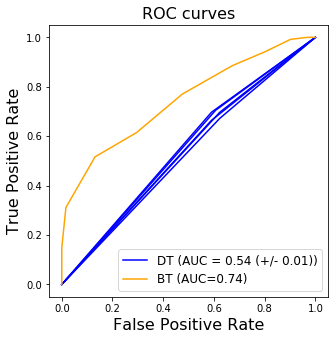

In [37]:
from sklearn import ensemble

# Initialize a bag of trees
clf = ensemble.BaggingClassifier()

# Cross-validate the bagging trees on the tumor data
ypred_bt = cross_validate_clf(X, y, clf, folds)

# Compute the ROC curve of the bagging trees
fpr_bt, tpr_bt, thresholds = metrics.roc_curve(y, ypred_bt, pos_label=1)
auc_bt = metrics.auc(fpr_bt, tpr_bt)

# Plot the ROC curve of the 5 decision trees from earlier
fig = plt.figure(figsize=(5, 5))

for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='blue') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='blue', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve of the bagging trees
plt.plot(fpr_bt, tpr_bt, color='orange', label='BT (AUC=%0.2f)' % auc_bt)


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

__Question:__ How do the bagging trees perform compared to individual trees?
    
__Answer:__

**Question** Use cross_validate_optimize to optimize the number of decision trees to use in the bagging method. How many trees did you find to be an optimal choice?

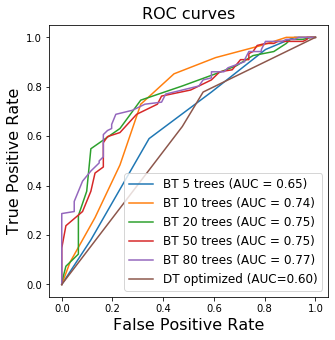

In [38]:
# Number of trees to use
list_n_trees = [5, 10, 20, 50, 80]

# Start a ROC curve plot
fig = plt.figure(figsize=(5, 5))
    
for idx, n_trees in enumerate(list_n_trees):
    # Initialize a bag of trees with n_trees trees
    clf = ensemble.BaggingClassifier(n_estimators=n_trees)
    
    # Cross-validate the bagging trees on the tumor data
    ypred_bt_tmp = cross_validate_clf(X, y, clf, folds)
    
    # Compute the ROC curve 
    fpr_bt_tmp, tpr_bt_tmp, thresholds = metrics.roc_curve(y, ypred_bt_tmp, pos_label=1)
    auc_bt_tmp = metrics.auc(fpr_bt_tmp, tpr_bt_tmp)

    # Plot the ROC curve
    plt.plot(fpr_bt_tmp, tpr_bt_tmp, '-', 
             label='BT %0.f trees (AUC = %0.2f)' % (n_trees, auc_bt_tmp))

# Plot the ROC curve of the optimal decision tree
plt.plot(fpr_dt_opt, tpr_dt_opt, label='DT optimized (AUC=%0.2f)' % auc_dt_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

## 3. Random Forest

In practice, simply bagging is typically not enough. In order to get a good reduction in variance, we require that the models being aggregated be uncorrelated, so that they make “different errors”. Bagging will usually get you highly correlated models that will make the same errors, and will therefore not reduce the variance of the combined predictor.

**Question** What is the difference between bagging trees and random forests? How does it intuitively fix the problem of correlations between trees ? 

__Answer:__

**Question** Cross-validate a random forest of 5 decision trees on the data. Plot the resulting ROC curve, compared to the bagging tree made of 5 decision trees.

Use [ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# Initialize a random forest with 5 trees
clf = # TODO

# Cross-validate the random forest on the tumor data
ypred_rf = # TODO

# Compute the ROC curve of the random forest
fpr_rf, tpr_rf, thresholds = # TODO
auc_rf = # TODO

# Plot the ROC curve of the 5 decision trees from earlier
fig = plt.figure(figsize=(5, 5))

for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='grey') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='grey', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve of the bagging trees (5 trees)
plt.plot(fpr_bt, tpr_bt, label='BT (AUC=%0.2f)' % auc_bt)

# Plot the ROC curve of the random forest (5 trees)
plt.plot(fpr_rf, tpr_rf, label='BT (AUC=%0.2f)' % auc_bt)


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

**Question** What are the main parameters of Random Forest which can be optimized ?

__Answer:__ 

**Question** Use cross_validate_clf_optimize to optimize 
* the number of decision trees 
* the number of features to consider at each split.

How many trees do you find to be an optimal choice? How does the optimal random forest compare to the optimal bagging trees? How do the training times of the random forest and the bagging trees compare?

In [ ]:
# Define the grid of parameters to test
param_grid = # TODO

# Initialize a GridSearchCV object that will be used to cross-validate
# a random forest with these parameters.
# What scoring function do you want to use?
clf = grid_search.GridSearchCV(# TODO

# Cross-validate the GridSearchCV object 
ypred_rf_opt = cross_validate_clf_optimize(X, y, clf, folds)

# Compute the ROC curve for the optimized random forest
fpr_rf_opt, tpr_rf_opt, thresholds = metrics.roc_curve(y, ypred_rf_opt, pos_label=1)
auc_rf_opt = metrics.auc(fpr_rf_opt, tpr_rf_opt)

# Plot the ROC curve of the optimized DecisionTreeClassifier
fig = plt.figure(figsize=(5, 5))

plt.plot(fpr_dt_opt, tpr_dt_opt, color='grey', 
         label='DT optimized (AUC=%0.2f)' % auc_dt_opt)
    
# Plot the ROC curve of the optimized random forest
plt.plot(fpr_bt_opt, tpr_bt_opt, 
         label='BT optimized (AUC=%0.2f)' % auc_bt_opt)

# Plot the ROC curve of the optimized bagging trees
plt.plot(fpr_rf_opt, tpr_rf_opt, l
         abel='RF optimized (AUC = %0.2f' % (auc_rf_opt))
    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

**Question** How do your tree-based classifiers compare to regularized logistic regression models? 
Plot the corresponding ROC curves.

In [ ]:
from sklearn import linear_model

# Evaluate an optimized l1-regularized logistic regression
param_grid = {'C': np.logspace(-3, 3, 7)}
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l1'), 
                               param_grid, scoring='roc_auc')
ypred_l1 = cross_validate_clf_optimize(X, y, clf, folds)
fpr_l1, tpr_l1, thresholds_l1 = metrics.roc_curve(y, ypred_l1, pos_label=1)
auc_l1 = metrics.auc(fpr_l1, tpr_l1)
print('nb features of best sparse model:', len(np.where(clf.best_estimator_.coef_!=0)[0]))

# Evaluate an optimized l2-regularized logistic regression
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), 
                               param_grid, scoring='roc_auc')
ypred_l2 = cross_validate_clf_optimize(X, y, clf, folds)
fpr_l2, tpr_l2, thresholds_l2 = metrics.roc_curve(y, ypred_l2, pos_label=1)
auc_l2 = metrics.auc(fpr_l2, tpr_l2)

In [ ]:
# Plot the ROC curves
fig = plt.figure(figsize=(5, 5))

plt.plot(fpr_rf_opt, tpr_rf_opt, 
         label='RF optimized (AUC = %0.2f)' % (auc_rf_opt))
plt.plot(fpr_bt_opt, tpr_bt_opt, 
         label='BT optimized (AUC = %0.2f)' % (auc_bt_opt))
plt.plot(fpr_l1, tpr_l1,  
         label='l1 optimized (AUC = %0.2f)' % (auc_l1))
plt.plot(fpr_l2, tpr_l2,  
         label='l2 optimized (AUC = %0.2f)' % (auc_l2))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)